In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm.notebook import tqdm

In [2]:

path = '../../../Atliq Marts Challenge'
fact_order_lines_df=pd.read_csv(path+"/fact_order_lines.csv")
# fact_orders_aggregate_df=pd.read_csv("Atliq Marts Challenge/fact_orders_aggregate.csv")

dim_date=pd.read_csv(path+"/dim_date.csv")
dim_customers=pd.read_csv(path+"/dim_customers.csv")
dim_products=pd.read_csv(path+"/dim_products.csv")
dim_targets_orders=pd.read_csv(path+"/dim_targets_orders.csv")
dim_date=pd.read_csv(path+"/dim_date.csv")
dim_date = dim_date.rename(columns={'date': 'agreed_delivery_date','mmm_yy': 'agreed_delivery_mmm_yy','week_no': 'agreed_delivery_week_num'})





In [3]:
# result =  pd.concat([fact_order_lines_df, fact_orders_aggregate_df], axis=1,join="outer")
# result =pd.merge( fact_order_lines_df, fact_orders_aggregate_df, on=["order_id", "customer_id"])
# esult =pd.merge( fact_order_lines_df, fact_orders_aggregate_df, on=["order_id", "customer_id"])
result =pd.merge( fact_order_lines_df ,dim_customers , how="outer",on=["customer_id"])
result =pd.merge( result ,dim_products , how="outer",on=["product_id"])
result =pd.merge( result ,dim_targets_orders , how="outer",on=["customer_id"])
df =pd.merge( result ,dim_date , how="outer",on=["agreed_delivery_date"])


In [4]:
df.head()

,order_id,order_placement_date,customer_id,product_id,order_qty,agreed_delivery_date,actual_delivery_date,delivery_qty,In Full,On Time,On Time In Full,customer_name,city,product_name,category,ontime_target%,infull_target%,otif_target%,agreed_delivery_mmm_yy,agreed_delivery_week_num
0,FMR32603203,01-Mar-22,789603.0,25891203.0,460.0,02-Mar-22,03-Mar-22,460.0,1.0,0.0,1.0,Info Stores,Vadodara,AM Butter 500,Dairy,92.0,75.0,69.0,Mar 22,W 10
1,FMR32401103,01-Mar-22,789401.0,25891103.0,476.0,02-Mar-22,02-Mar-22,476.0,1.0,1.0,1.0,Propel Mart,Surat,AM Milk 100,Dairy,85.0,79.0,67.0,Mar 22,W 10
2,FMR32320302,01-Mar-22,789320.0,25891203.0,347.0,02-Mar-22,02-Mar-22,347.0,1.0,1.0,1.0,Chiptec Stores,Surat,AM Butter 500,Dairy,91.0,81.0,74.0,Mar 22,W 10
3,FMR32320302,01-Mar-22,789320.0,25891302.0,54.0,02-Mar-22,02-Mar-22,54.0,1.0,1.0,1.0,Chiptec Stores,Surat,AM Ghee 150,Dairy,91.0,81.0,74.0,Mar 22,W 10
4,FMR32320202,01-Mar-22,789320.0,25891202.0,211.0,02-Mar-22,03-Mar-22,211.0,1.0,0.0,1.0,Chiptec Stores,Surat,AM Butter 250,Dairy,91.0,81.0,74.0,Mar 22,W 10


In [5]:
df.dropna(inplace=True)

In [6]:
np.sum(df.isna())

order_id                    0
order_placement_date        0
customer_id                 0
product_id                  0
order_qty                   0
agreed_delivery_date        0
actual_delivery_date        0
delivery_qty                0
In Full                     0
On Time                     0
On Time In Full             0
customer_name               0
city                        0
product_name                0
category                    0
ontime_target%              0
infull_target%              0
otif_target%                0
agreed_delivery_mmm_yy      0
agreed_delivery_week_num    0
dtype: int64

In [7]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df.rename(columns=lambda x: x.replace("(", "").replace(")", ""), inplace=True)
df.rename(columns=lambda x: x.replace("%", "_percent"), inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56796 entries, 0 to 57095
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  56796 non-null  object 
 1   order_placement_date      56796 non-null  object 
 2   customer_id               56796 non-null  float64
 3   product_id                56796 non-null  float64
 4   order_qty                 56796 non-null  float64
 5   agreed_delivery_date      56796 non-null  object 
 6   actual_delivery_date      56796 non-null  object 
 7   delivery_qty              56796 non-null  float64
 8   in_full                   56796 non-null  float64
 9   on_time                   56796 non-null  float64
 10  on_time_in_full           56796 non-null  float64
 11  customer_name             56796 non-null  object 
 12  city                      56796 non-null  object 
 13  product_name              56796 non-null  object 
 14  catego

In [9]:
df['actual_delivery_date_formatted'] = pd.to_datetime(df['actual_delivery_date'], format='%d-%b-%y')

df = df.sort_values(by='actual_delivery_date_formatted')

In [10]:
df = df[(df['product_id'] == 25891103)] 

In [11]:
# feature = ['customer_name','product_name','delivery_qty','in_full','on_time','on_time_in_full','city','category','ontime_target_percent','infull_target_percent','otif_target_percent','order_qty']
# feature = ['customer_name','product_name','city','category','ontime_target_percent','infull_target_percent','otif_target_percent','order_qty']
feature = ['customer_name','product_name','city','category','ontime_target_percent','infull_target_percent','otif_target_percent','order_qty','agreed_delivery_mmm_yy','agreed_delivery_week_num']

df = df[feature]

In [12]:
df = df.drop_duplicates()
# Check for duplicated rows
duplicated_rows = df.duplicated()

# Filter the DataFrame to show duplicated rows
duplicated_df = df[duplicated_rows]

print("Duplicated Rows:")
print(duplicated_df)

Duplicated Rows:
Empty DataFrame
Columns: [customer_name, product_name, city, category, ontime_target_percent, infull_target_percent, otif_target_percent, order_qty, agreed_delivery_mmm_yy, agreed_delivery_week_num]
Index: []


In [13]:
Obj_feature = ['customer_name','product_name','city','category']
for e in Obj_feature:
    tmp = pd.get_dummies(df[e],drop_first=True)
    df.drop([e],axis=1,inplace=True)
    df = pd.concat([df,tmp],axis=1)
df.shape

(3149, 22)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3149 entries, 82 to 56862
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ontime_target_percent     3149 non-null   float64
 1   infull_target_percent     3149 non-null   float64
 2   otif_target_percent       3149 non-null   float64
 3   order_qty                 3149 non-null   float64
 4   agreed_delivery_mmm_yy    3149 non-null   object 
 5   agreed_delivery_week_num  3149 non-null   object 
 6   Atlas Stores              3149 non-null   uint8  
 7   Chiptec Stores            3149 non-null   uint8  
 8   Coolblue                  3149 non-null   uint8  
 9   Elite Mart                3149 non-null   uint8  
 10  Expert Mart               3149 non-null   uint8  
 11  Expression Stores         3149 non-null   uint8  
 12  Info Stores               3149 non-null   uint8  
 13  Logic Stores              3149 non-null   uint8  
 14  Lotus 

In [15]:
df[['month', 'year']] = df['agreed_delivery_mmm_yy'].str.split(' ', expand=True)
df.drop(['agreed_delivery_mmm_yy'],axis=1,inplace=True)
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

# Replace month names with numeric values
df['month'] = df['month'].replace(month_mapping)

df[['W', 'agreed_delivery_week_no']] = df['agreed_delivery_week_num'].str.split(' ', expand=True)
df.drop(['agreed_delivery_week_num'],axis=1,inplace=True)
df.drop(['W'],axis=1,inplace=True)

In [16]:

def read_data (months,df):
    i=0
    for month in months:
        if i !=0:
            features_temp=df[df['month']==month] .loc[:, df[df['month']==month] .columns !='order_qty']
            labels_temp=df[df['month']==month] .loc[:, df[df['month']==month] .columns =='order_qty']
            features = pd.concat([features, features_temp])
            labels = pd.concat([labels, labels_temp])
        else :
            features=df[df['month']==month] .loc[:, df[df['month']==month] .columns !='order_qty']
            labels=df[df['month']==month].loc[:, df[df['month']==month] .columns =='order_qty']
        i+=1
    return features,labels


In [17]:

x_train, y_train = read_data([3,4,5,6],df)
# use data from month 9 as validation set
x_val, y_val = read_data([7],df)

# use data from month 10 as test set
x_test, y_test = read_data([8],df)
print('x_train shape:',x_train.shape)
print('y_train shape:', y_train.shape, '\n')
print('x_val shape:',x_val.shape)
print('y_val shape:', y_val.shape, '\n')
print('x_test shape:',x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (2041, 22)
y_train shape: (2041, 1) 

x_val shape: (564, 22)
y_val shape: (564, 1) 

x_test shape: (544, 22)
y_test shape: (544, 1)


In [18]:

def extract_X(df, ntimesteps): 
    features = len(df.columns)
    X = list()
    
    #offset for timesteps
    offsets = list()
    for i in range (ntimesteps, 0, -1): 
        offsets.append(df.shift(i))
        
    #combine timestep columns into rows 
    combined = pd.concat(offsets, axis=1)
    combined = combined.tail(-ntimesteps) 
    combined.drop(combined.tail(1).index, inplace=True)
    
    #reshape each row (timesteps, features)
    for i in range(len(combined)): 
        row = combined.iloc[i].to_numpy()
        xrow = list()
        for n in range(ntimesteps): 
            xrow.append(row[n*features:(n*features)+features])
        X.append(xrow)
    
    #return as numpy array
    return np.array(X)

def extract_y(df, col_name, ntimesteps): 
    shifted = df.shift(-1)
    shifted = shifted.head(-2)
    shifted = shifted.tail(-(ntimesteps-1))
    return shifted[col_name].values


def normalizer_std_gru(X):
    scaler = preprocessing.StandardScaler().fit(X.reshape(len(X), -1))
    return scaler

class RainfallDatasetGRU(Dataset):
    def __init__(self, x, y, normalizer):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        self.normalizer = normalizer
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        x = self.normalizer.transform(x.flatten().reshape(1, -1)).reshape(x.shape)
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]
timestep = 10
x_train = extract_X(x_train,timestep)
x_val = extract_X(x_val,timestep)
x_test = extract_X(x_test,timestep)

y_train = extract_X(y_train,timestep)
y_val = extract_X(y_val,timestep)
y_test = extract_X(y_test,timestep)


y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1]))
y_val =np.reshape(y_val, (y_val.shape[0], y_val.shape[1]))
y_test =np.reshape(y_test, (y_test.shape[0], y_test.shape[1]))
# y_train = extract_y(y_train,'order_qty',5)
# y_val = extract_y(y_val,'order_qty',5)
# y_test = extract_y(y_test,'order_qty',5)

# train_dataset = RainfallDatasetFF(x_train.to_numpy(), y_train.to_numpy(), normalizer)
# val_dataset = RainfallDatasetFF(x_val.to_numpy(), y_val.to_numpy(), normalizer)
# test_dataset = RainfallDatasetFF(x_test.to_numpy(), y_test.to_numpy(), normalizer)

normalizer = normalizer_std_gru(x_train)

train_dataset = RainfallDatasetGRU(x_train, y_train, normalizer)
val_dataset = RainfallDatasetGRU(x_val, y_val, normalizer)
test_dataset = RainfallDatasetGRU(x_test, y_test, normalizer)

(2030, 10, 22)
(2030, 10)
(553, 10, 22)
(553, 10)
(533, 10, 22)
(533, 10)


In [19]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

In [20]:
loss_fn = nn.L1Loss()

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
# class GRU_Neural_Network(nn.Module):
#     def __init__(self):
#         super(GRU_Neural_Network, self).__init__()
#         self.gru = nn.GRU(x_train.shape[2], 200, batch_first=True)
#         self.ff1 = nn.Linear(200, 200)
#         self.ff2 = nn.Linear(200, 200)
#         self.out = nn.Linear(200, 1)

#     def forward(self, x):
#         hd1, _ = self.gru(x)
#         hd1 = F.relu(self.ff1(hd1))   
#         hd1 = F.relu(self.ff2(hd1))
#         y = self.out(hd1)
#         return y.reshape(-1, timestep)

In [23]:
class GRU_Neural_Network(nn.Module):
    def __init__(self):
        super(GRU_Neural_Network, self).__init__()
        self.gru = nn.GRU(x_train.shape[2], 200, batch_first=True)
        self.do1 = nn.Dropout(p=0.3)
        self.ff1 = nn.Linear(200, 200)
        self.do2 = nn.Dropout(p=0.3)
        self.ff2 = nn.Linear(200, 200)
        self.out = nn.Linear(200, 1)

    def forward(self, x):
        hd1, _ = self.gru(x)
        hd2 = F.relu(self.do1(hd1))
        hd3 = F.relu(self.ff1(hd2))    
        hd4 = F.relu(self.do2(hd3))
        hd5 = F.relu(self.ff2(hd4))
        y = self.out(hd5)
        return y.reshape(-1, timestep)

In [24]:
config = {
    'architecture': 'GRU',
    'lr': 0.01,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 30
}

# Model
model_gru = GRU_Neural_Network()
model_gru = model_gru.to(device)
optimizer = torch.optim.Adam(model_gru.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr']
)

In [25]:
summary(model_gru, input_size=(64, 5, x_train.shape[2]))

Layer (type:depth-idx)                   Output Shape              Param #
GRU_Neural_Network                       [32, 10]                  --
├─GRU: 1-1                               [64, 5, 200]              134,400
├─Dropout: 1-2                           [64, 5, 200]              --
├─Linear: 1-3                            [64, 5, 200]              40,200
├─Dropout: 1-4                           [64, 5, 200]              --
├─Linear: 1-5                            [64, 5, 200]              40,200
├─Linear: 1-6                            [64, 5, 1]                201
Total params: 215,001
Trainable params: 215,001
Non-trainable params: 0
Total mult-adds (M): 48.17
Input size (MB): 0.03
Forward/backward pass size (MB): 1.54
Params size (MB): 0.86
Estimated Total Size (MB): 2.43

In [26]:


train_losses = []
val_losses = []
learning_rates = []

for epoch in range(config['epochs']):  # loop over the dataset multiple times

    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_gru.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_gru(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()

        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model_gru.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model_gru(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_gru.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }

            print(f"Saving new best model..")
            torch.save(state, "model_gru.pth.tar")

Training epoch 1...
Current LR: 0.01


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1 train loss: 151.1909
Validating epoch 1


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1 val loss: 72.3101
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2 train loss: 63.5283
Validating epoch 2


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2 val loss: 48.9661
Saving new best model..
Training epoch 3...
Current LR: 0.01


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3 train loss: 56.8078
Validating epoch 3


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3 val loss: 48.5328
Saving new best model..
Training epoch 4...
Current LR: 0.01


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4 train loss: 56.5467
Validating epoch 4


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4 val loss: 48.5360
Training epoch 5...
Current LR: 0.01


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5 train loss: 55.9441
Validating epoch 5


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5 val loss: 49.0586
Training epoch 6...
Current LR: 0.01


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6 train loss: 56.0211
Validating epoch 6


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6 val loss: 49.5815
Training epoch 7...
Current LR: 0.002


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7 train loss: 55.6136
Validating epoch 7


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7 val loss: 48.2515
Saving new best model..
Training epoch 8...
Current LR: 0.002


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8 train loss: 56.1908
Validating epoch 8


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8 val loss: 48.3807
Training epoch 9...
Current LR: 0.002


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9 train loss: 55.5208
Validating epoch 9


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9 val loss: 48.8531
Training epoch 10...
Current LR: 0.002


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10 train loss: 55.6107
Validating epoch 10


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10 val loss: 48.3451
Training epoch 11...
Current LR: 0.0004


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11 train loss: 55.3597
Validating epoch 11


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11 val loss: 48.3912
Training epoch 12...
Current LR: 0.0004


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12 train loss: 55.7953
Validating epoch 12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12 val loss: 48.5395
Training epoch 13...
Current LR: 0.0004


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13 train loss: 55.2359
Validating epoch 13


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13 val loss: 48.4448
Training epoch 14...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14 train loss: 55.6632
Validating epoch 14


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14 val loss: 48.5449
Training epoch 15...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15 train loss: 55.3520
Validating epoch 15


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15 val loss: 48.4113
Training epoch 16...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16 train loss: 55.3982
Validating epoch 16


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16 val loss: 48.5243
Training epoch 17...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17 train loss: 55.0886
Validating epoch 17


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17 val loss: 48.5693
Training epoch 18...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18 train loss: 55.2549
Validating epoch 18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18 val loss: 48.4182
Training epoch 19...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19 train loss: 55.3506
Validating epoch 19


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19 val loss: 48.5637
Training epoch 20...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20 train loss: 55.5824
Validating epoch 20


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20 val loss: 48.5084
Training epoch 21...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21 train loss: 54.9859
Validating epoch 21


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21 val loss: 48.4792
Training epoch 22...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22 train loss: 55.4308
Validating epoch 22


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22 val loss: 48.5573
Training epoch 23...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23 train loss: 55.3233
Validating epoch 23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23 val loss: 48.4820
Training epoch 24...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24 train loss: 55.5347
Validating epoch 24


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 24 val loss: 48.4037
Training epoch 25...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25 train loss: 55.2768
Validating epoch 25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25 val loss: 48.4149
Training epoch 26...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26 train loss: 54.8765
Validating epoch 26


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 26 val loss: 48.5176
Training epoch 27...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27 train loss: 55.2078
Validating epoch 27


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 27 val loss: 48.5789
Training epoch 28...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28 train loss: 55.2903
Validating epoch 28


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 28 val loss: 48.3848
Training epoch 29...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29 train loss: 55.3819
Validating epoch 29


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 29 val loss: 48.5979
Training epoch 30...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30 train loss: 55.3018
Validating epoch 30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30 val loss: 48.6509


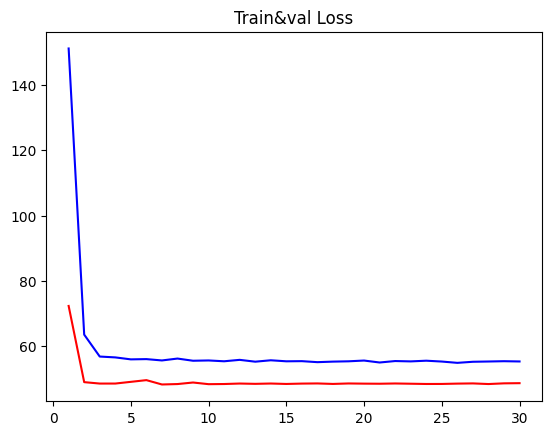

In [27]:
x = [i + 1 for i in range(config['epochs'])]

plt.plot(x, train_losses,color = 'blue')
plt.title("Train&val Loss")
plt.plot(x, val_losses,color = 'red')

plt.show()

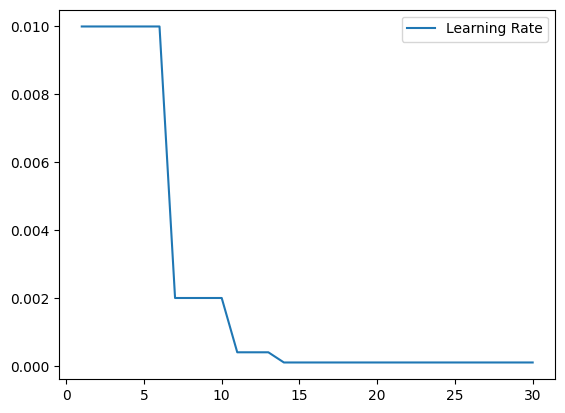

In [28]:
plt.plot(x, learning_rates, label="Learning Rate")
plt.legend()
plt.show()

In [29]:
# Assuming you have defined your model (model_gru) and loaded the test dataset (test_loader)

# Load the best model checkpoint
checkpoint = torch.load("model_gru.pth.tar")
model_gru.load_state_dict(checkpoint['model'])

# Set model to evaluation mode
model_gru.eval()

# Make predictions on the test set
predictions = []
with torch.no_grad():
    for inputs, _ in test_loader:  # assuming test_loader yields (inputs, _), where _ is ignored
        inputs = inputs.to(device)  # Transfer data to GPU if available
        y_pred = model_gru(inputs)
        predictions.append(y_pred.cpu().numpy())  # Convert predictions to numpy array and move to CPU

# Concatenate predictions into a single numpy array
predictions = np.concatenate(predictions)

# Now you have predictions for the test set, you can further process or analyze them as needed.


In [30]:
predictions

array([[439.25974, 402.92023, 405.28302, ..., 402.83176, 390.73773,
        402.0842 ],
       [424.61957, 421.97025, 406.29456, ..., 391.10834, 402.44354,
        406.15204],
       [401.73306, 380.86102, 406.57214, ..., 402.46048, 406.1643 ,
        405.25958],
       ...,
       [412.78906, 371.7633 , 406.05865, ..., 404.00726, 406.01822,
        405.21255],
       [417.30902, 384.0658 , 406.17865, ..., 406.2431 , 405.4397 ,
        406.24268],
       [404.48727, 417.18378, 406.27716, ..., 405.4925 , 406.29346,
        402.8321 ]], dtype=float32)

In [31]:
y_test

array([[481., 471., 372., ..., 485., 325., 408.],
       [471., 372., 397., ..., 325., 408., 309.],
       [372., 397., 442., ..., 408., 309., 327.],
       ...,
       [351., 353., 420., ..., 433., 388., 414.],
       [353., 420., 302., ..., 388., 414., 322.],
       [420., 302., 459., ..., 414., 322., 434.]])

In [32]:

results_df =pd.DataFrame({"Actual": y_test[:, 0], "Predict": predictions[:, 0]})

In [33]:
results_df

,Actual,Predict
0,481.0,439.259735
1,471.0,424.619568
2,372.0,401.733063
3,397.0,439.259735
4,442.0,388.559143
...,...,...
528,477.0,422.970184
529,483.0,408.121979
530,351.0,412.789062
531,353.0,417.309021


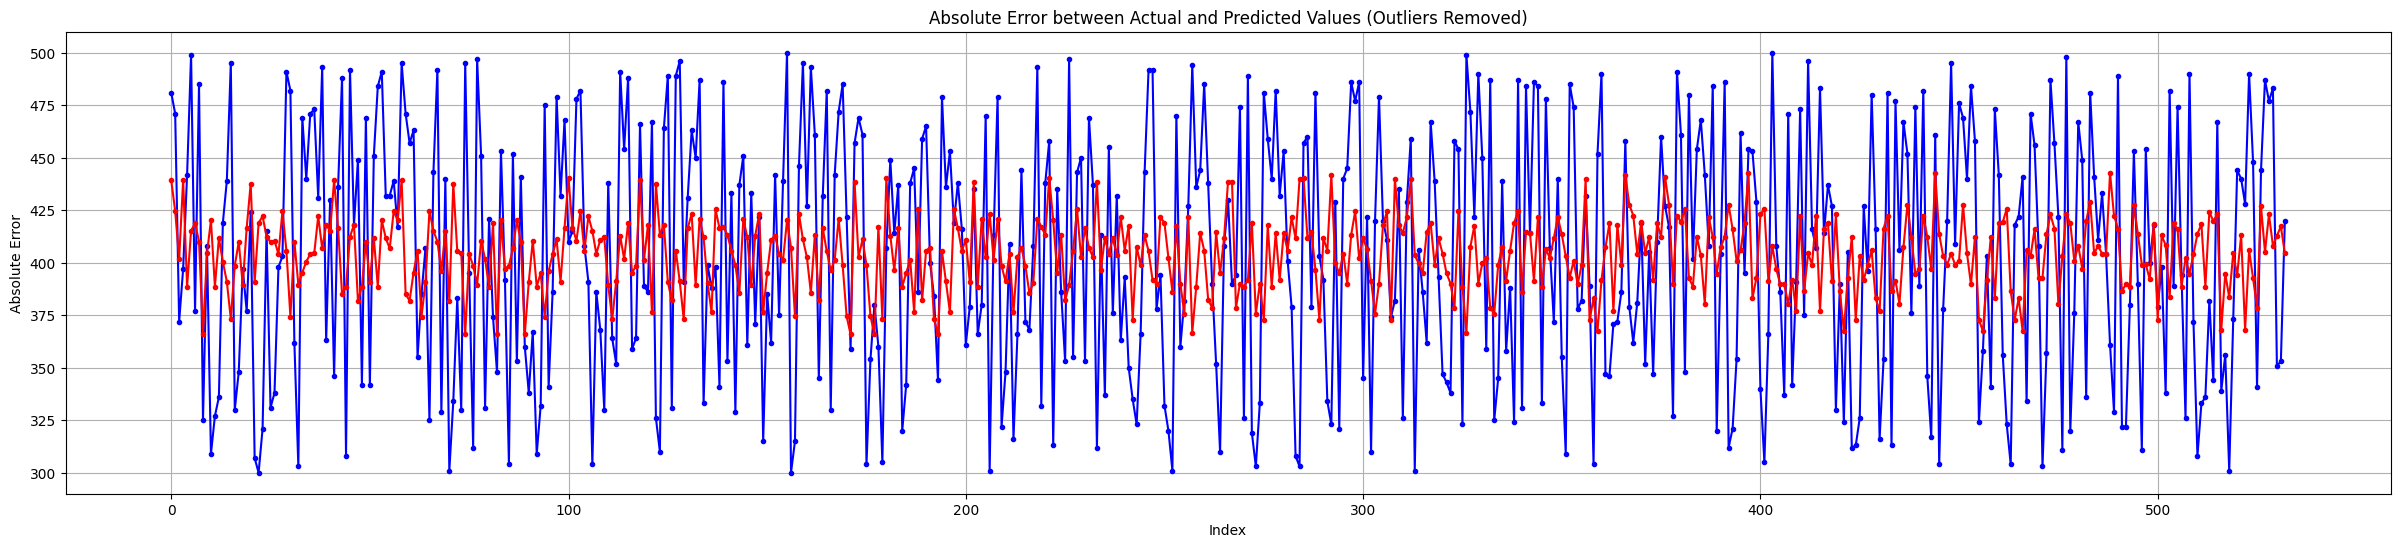

In [34]:
results_df['Abs_Error'] = abs(results_df['Actual'] - results_df['Predict'])
plt.figure(figsize=(30, 6))
plt.plot( results_df['Actual'], color='blue', marker='.', linestyle='-', label='Original Data')
plt.plot( results_df['Predict'], color='red', marker='.', label='6-Week Moving Average')
plt.title('Absolute Error between Actual and Predicted Values (Outliers Removed)')
plt.xlabel('Index')
plt.ylabel('Absolute Error')
plt.grid(True)
plt.show()

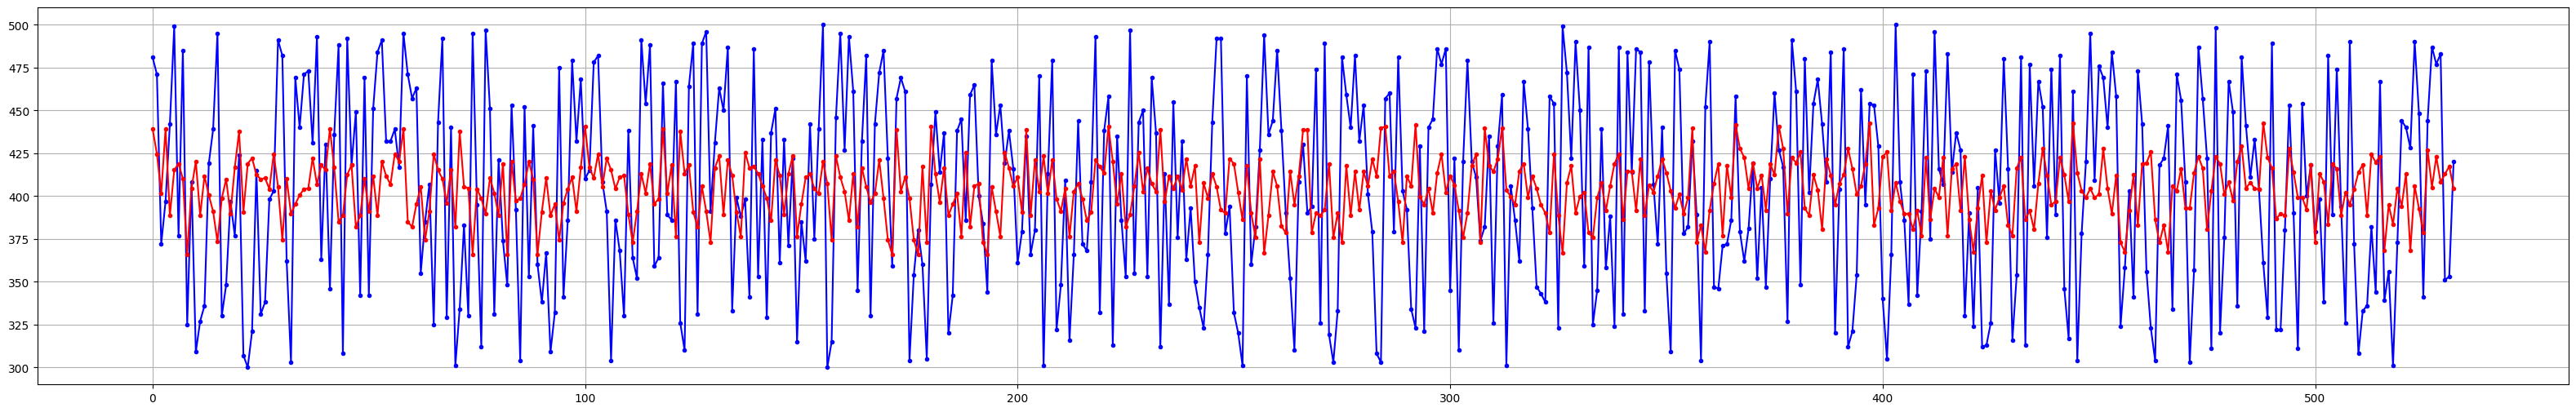

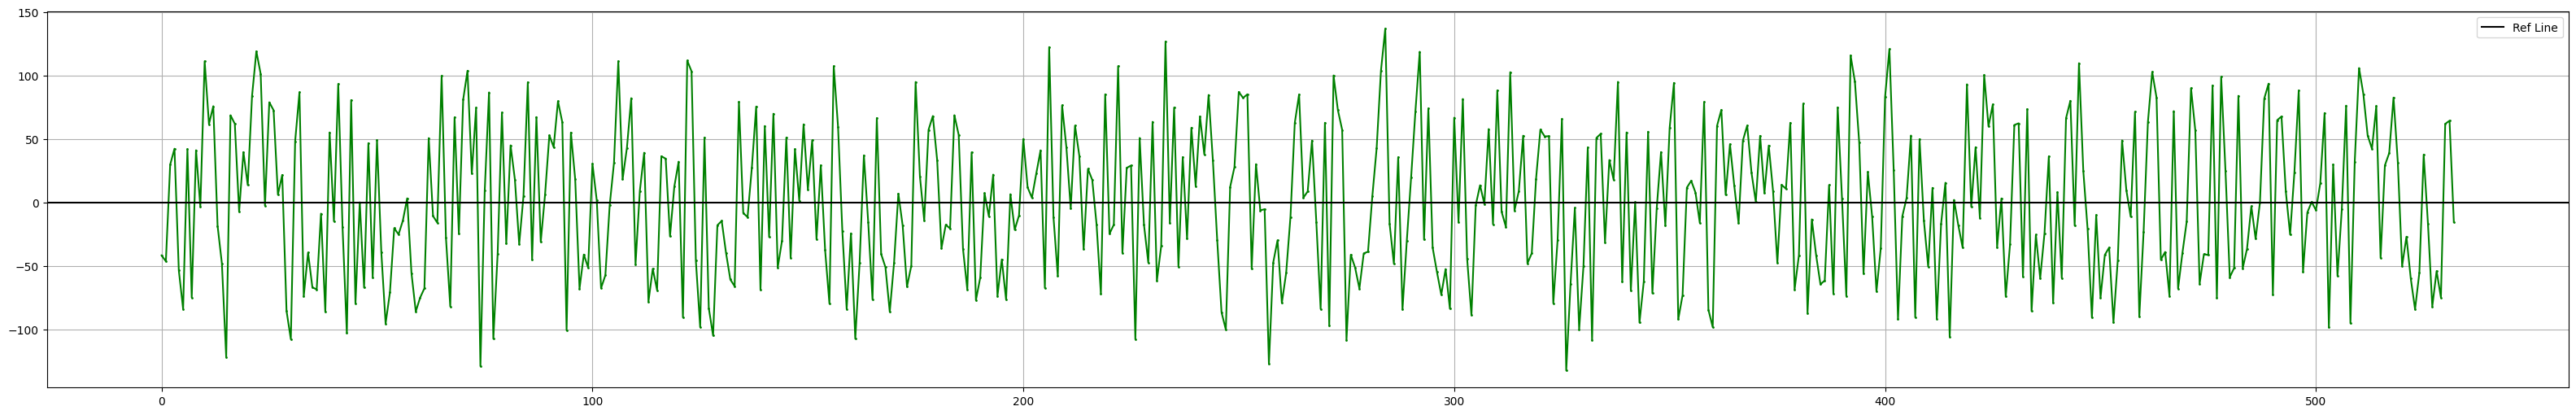

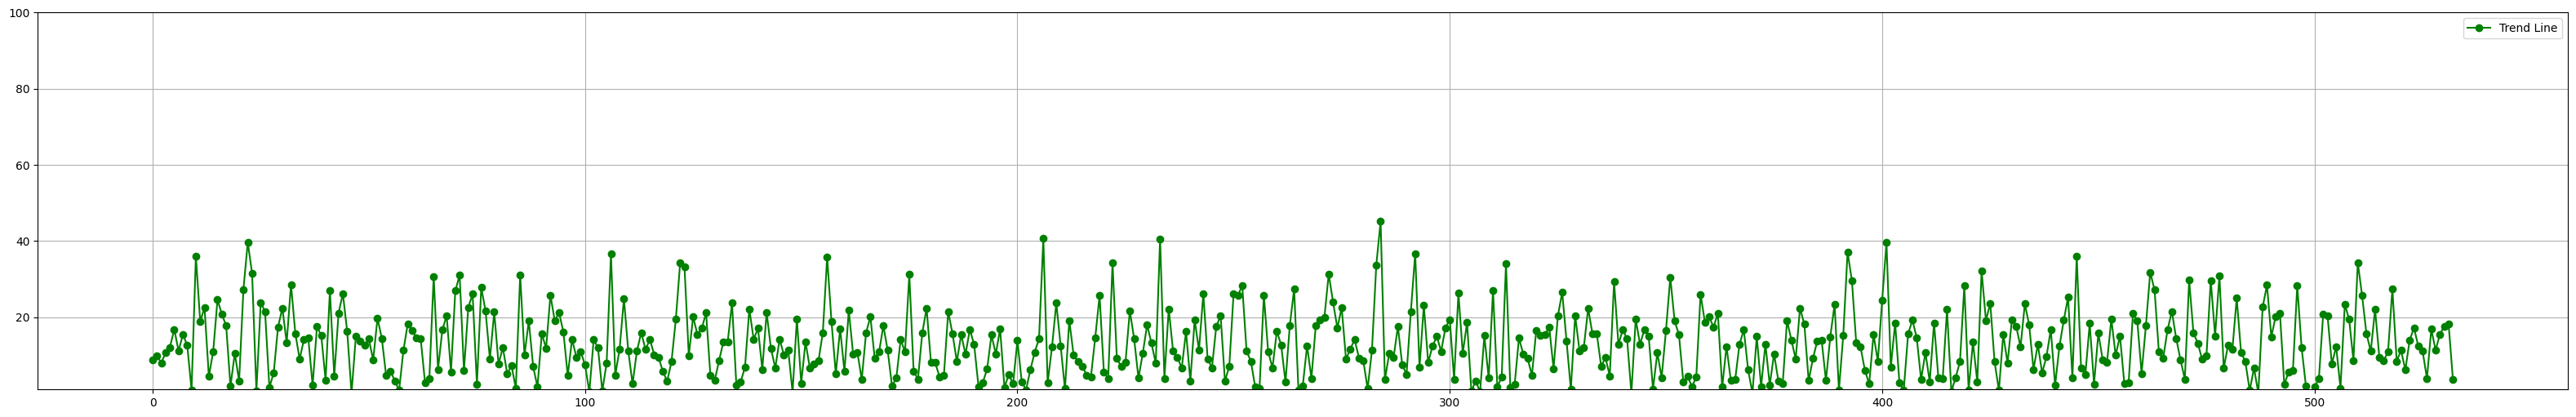

In [35]:
plt.figure(figsize=(40, 6))
plt.plot( results_df['Actual'], color='blue', marker='.', linestyle='-', label='Original Data')
plt.plot( results_df['Predict'], color='red', marker='.', label='6-Week Moving Average')
plt.grid(True)
plt.show()

plt.figure(figsize=(40, 6))
# plt.plot(df['moving_avg']-df['order_qty'], color='red', marker='o', linestyle='-', label='Trend Line')
plt.plot( results_df['Predict']-results_df['Actual'], color='green', marker='o', linestyle='-', markersize=1)
plt.axhline(y=0, color='black', linestyle='-', label='Ref Line')

plt.grid(True)
plt.legend()  # Show legend
plt.show()

plt.figure(figsize=(40, 6))
# plt.plot( (abs(df['moving_avg'] - df['order_qty']) / df['order_qty']) * 100, color='red', marker='o', linestyle='-', label='Trend Line')
plt.plot( (abs(results_df['Predict'] - results_df['Actual']) / results_df['Actual']) * 100, color='green', marker='o', linestyle='-', label='Trend Line')

plt.grid(True)
plt.legend()  # Show legend
plt.ylim(1, 100)  # Set y-axis limits
plt.show()